## Libraries

In [ ]:
import os
import glob
import pandas as pd
import numpy as np
import json
from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.dates import DateFormatter
from matplotlib.patches import Polygon as matPolygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from shapely.geometry import Point, Polygon
import ast
import sys
import importlib
sys.path.append('../') 
import modelling.spatiotemporal_diffusion as spd
importlib.reload(spd)

<module 'modelling.spatiotemporal_diffusion' from '/Users/nb22i345/Documents/PostDoc/patient_flows/analysis/../modelling/spatiotemporal_diffusion.py'>

## Data


### Building

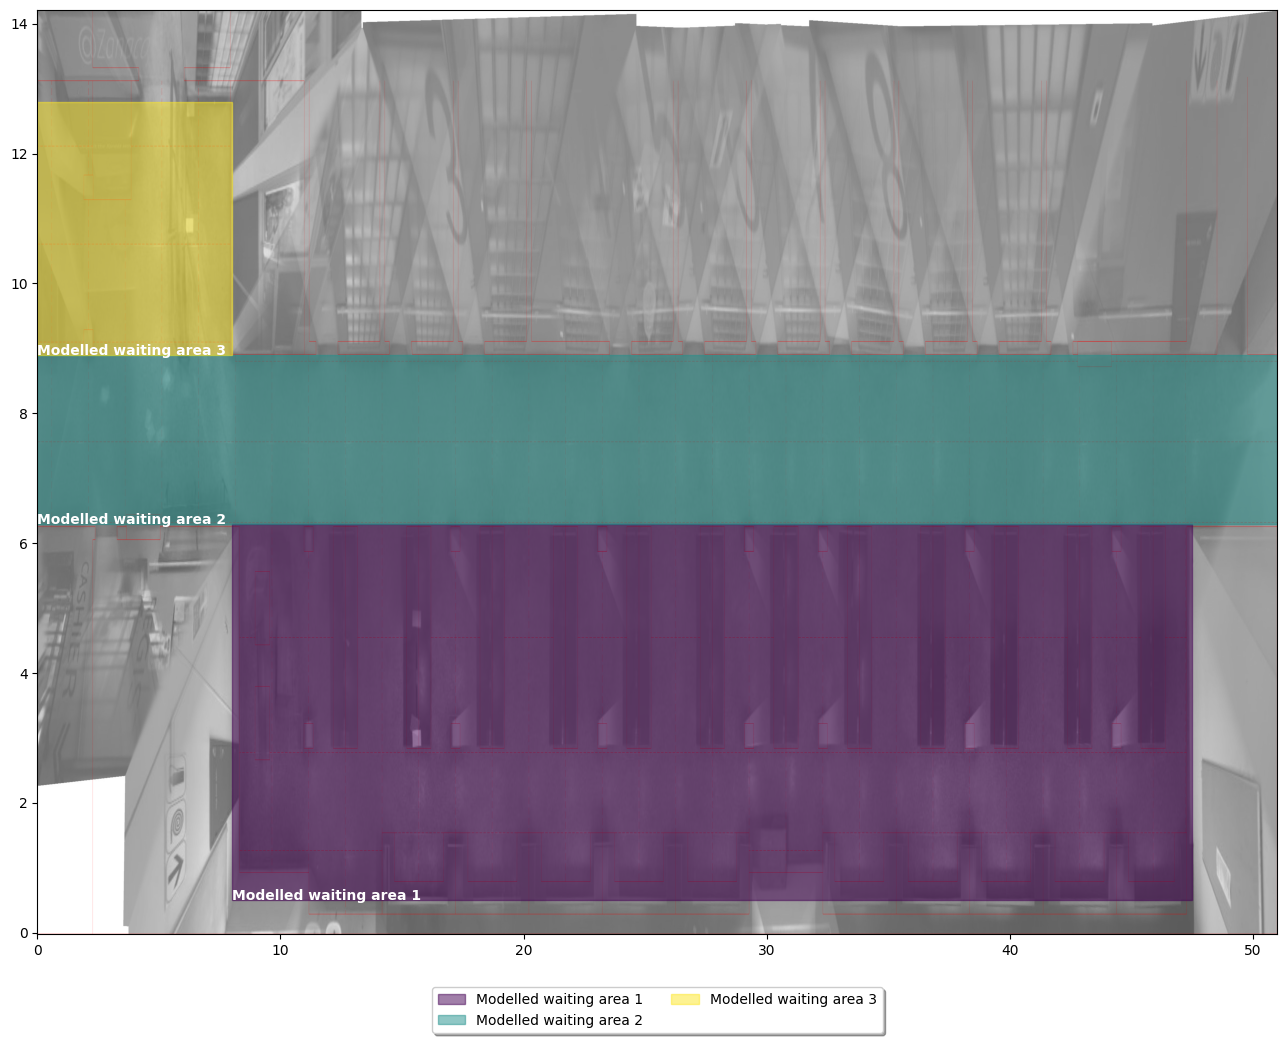

In [2]:
def plot_with_background(ax, alpha = .5):
	"""
	Creates a plot with a background image.

	Parameters:
	- ax: The matplotlib axis object containing the plot.
	"""
	# Path to your image file
	image_path = '../data-raw/background/image3195.png'
	
	# Coordinates for the image placement
	image_extent = (0, 51, -0.02, 14.214)

	# Load the background image
	img = mpimg.imread(image_path)
	
	# If an extent is provided, use it to correctly scale and position the image
	if image_extent:
		ax.imshow(img, aspect='auto', extent=image_extent, zorder=-1, alpha = alpha)
	else:
		ax.imshow(img, aspect='auto', zorder=-1, alpha = alpha)
	
	return ax

# Add geomtries
with open('../data-raw/background/config.json') as f:
	data = json.load(f)
geometries = []

# Entries and exits  
waiting_area_1 = [[8, 0.5], [47.5, 0.5], [47.5, 6.3], [8, 6.3]]
waiting_area_1 = {
	'geometry': waiting_area_1,
	'type': 'ZONE',
	'name': 'Modelled waiting area 1'
}
geometries.append(waiting_area_1)
waiting_area_2 = [[0, 6.3], [51, 6.3], [51, 8.9], [0, 8.9]]
waiting_area_2 = {
	'geometry': waiting_area_2,
	'type': 'ZONE',
	'name': 'Modelled waiting area 2'
}
geometries.append(waiting_area_2)
waiting_area_3 = [[0, 8.9], [8, 8.9], [8, 12.8], [0, 12.8]]
waiting_area_3 = {
	'geometry': waiting_area_3,
	'type': 'ZONE',
	'name': 'Modelled waiting area 3'
}
geometries.append(waiting_area_3)


def plot_with_background_geom(ax, geometries):
	"""
	Plots the geometries on a background image.

	Parameters:
	- ax: The matplotlib axes object where the plot will be drawn.
	- geometries: A list of geometry dictionaries, each containing 'geometry', 'type', and 'name' keys.

	Returns:
	- The modified axes object with the geometries plotted.
	"""
	# Plot the background image first
	ax = plot_with_background(ax, 1)

	# Color cycle for different polygons
	colors = plt.cm.viridis(np.linspace(0, 1, len(geometries)))

	for i, geometry in enumerate(geometries):
		# Extract the coordinates directly from the 'geometry' key
		coords = geometry['geometry']
		
		# Check if the geometry is a LINE or a ZONE to decide on closure
		if geometry['type'] == 'ZONE':
			closed = True
		else:  # For 'LINE', do not close the polygon
			closed = False
		
		# Create a polygon or line from the coordinates
		polygon = matPolygon(xy=coords, closed=closed, color=colors[i], label=geometry['name'], alpha=0.5)
		
		# Add the polygon or line to the plot
		ax.add_patch(polygon)
		
		# Label the polygon or line with its name
		# Use the first vertex for the label position
		ax.annotate(geometry['name'], xy=coords[0], color='white', weight='bold')

	# Adjust the legend to be below the plot
	ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)

	return ax

fig, ax = plt.subplots(figsize=(16, 12))
ax = plot_with_background_geom(ax, geometries)
plt.show()

### Building parameter assumptions

The volume of the waiting area is an important parameter for the computation of the air exchange rate and the diffusion rate. Furthermore, we assume a vertically mixed space, which matters for the quanta exposure, especially initially when the quanta are released. We make the following simplifying assumptions: 
1. We assume that the waiting area is closed even though there are entries on the left and right side to further parts of the clinic.
2. The height in the main area 1 and 2 is diagonal with the height increasing from 3m to 4.4m. We assume a fixed height of 3m, limiting the vertcal mixing and thus the quanta exposure. Furthermore, there are columns inside the building that would also have to be subtracted from the volume.  

In [3]:
# waiting hall
def polygon_area(coords):
	x, y = zip(*coords)
	return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))

height = 3  # m

area1 = polygon_area(waiting_area_1['geometry'])
area2 = polygon_area(waiting_area_2['geometry'])
area3 = polygon_area(waiting_area_3['geometry'])

vol1 = area1 * height
vol2 = area2 * height
vol3 = area3 * height
combined_vol = vol1 + vol2 + vol3

print(f"Volume waiting_area_1: {vol1:.2f} m³")
print(f"Volume waiting_area_2: {vol2:.2f} m³")
print(f"Volume waiting_area_3: {vol3:.2f} m³")
print(f"Combined volume: {combined_vol:.2f} m³")

Volume waiting_area_1: 687.30 m³
Volume waiting_area_2: 397.80 m³
Volume waiting_area_3: 93.60 m³
Combined volume: 1178.70 m³


### Waiting room grid

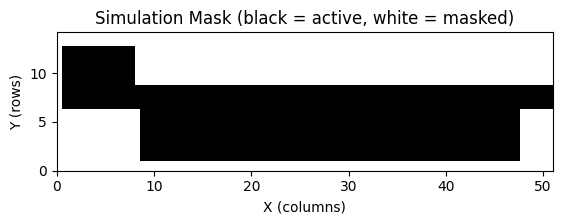

In [5]:
# Create grid coordinates
image_extent = (0, 51, -0.02, 14.214)
x1, x2, y1, y2 = image_extent
cell_size = 0.5

x_grid = np.arange(x1, x2, cell_size)
y_grid = np.arange(y1, y2, cell_size)

# Create meshgrid
xx, yy = np.meshgrid(x_grid, y_grid)
grid_shape = xx.shape

# Initialize zero matrix
zero_matrix = np.zeros(grid_shape)

# Prepare polygons for masking
polygons = [Polygon(area['geometry']) for area in [waiting_area_1, waiting_area_2, waiting_area_3]]

# Create binary mask
mask = np.zeros(grid_shape, dtype=bool)
for i in range(grid_shape[0]):
	for j in range(grid_shape[1]):
		point = Point(xx[i, j], yy[i, j])
		mask[i, j] = any(poly.contains(point) for poly in polygons)
  

plt.imshow(mask, origin='lower', extent=[x1, x2, y1, y2], cmap="gray_r")
plt.title("Simulation Mask (black = active, white = masked)")
plt.xlabel("X (columns)")
plt.ylabel("Y (rows)")
plt.show()

In [6]:
# cell volume
cell_volume = cell_size**2 * height # m^3
cell_volume

0.75

### Tracking data

In [7]:
tb_pos_df = pd.read_csv('../data-clean/tracking/tb-positions/2024-06-26.csv')
non_tb_ps_df = pd.read_csv('../data-clean/tracking/non-tb-positions/2024-06-26.csv')
tb_pos_df

,time,positions,dt
0,0,[],15490
1,15490,"[(222939, 30, 17, 1)]",1
2,15491,"[(222939, 28, 16, 1)]",1
3,15492,"[(222939, 27, 16, 1)]",1
4,15493,"[(222939, 24, 15, 1)]",1
...,...,...,...
6474,38241,"[(255676, 33, 16, 1)]",1
6475,38242,"[(255676, 32, 16, 1)]",1
6476,38243,"[(255676, 30, 17, 1)]",1
6477,38244,"[(255676, 30, 17, 0)]",1


In [8]:
# Compute total person time of TB patients in hours
total_person_time_seconds = sum(len(ast.literal_eval(row['positions'])) * row['dt'] for _, row in tb_pos_df.iterrows())
total_person_time_hours = total_person_time_seconds / 3600
print(f"Total TB patient person time in clinic: {total_person_time_hours:.2f} hours")

Total TB patient person time in clinic: 14.51 hours


### Environmental data

There are two devices installed in the clinic. One device was closer to the reception where most people were, especially if the clinic was not really crowded. Furthermore, the air exchange rate was computed using a transient mass balance model, which considers time-varying room occupancy as well as increase and decay in CO2 levels, and a steady-state model, which assumes a steady state occupancy and corresponding CO2 level to compute the air exchange rate. The air exchange rate as calculated by the transient mass balance model are probably more realistic but were always higher than the ones computed by the steady-state model. 

We use the air exchange rates as computed by the transient mass balance model (indicating better ventilation) but from the device closer to the reception (indicating worse ventilation). 

In [9]:
aer_df = pd.read_csv('../data-clean/environmental/air-exchange-rate.csv')
aer_df[aer_df['date'] == '2024-06-26']

,device,date,aer_tmb,Cr_tmb,aer_ssm,Cr_ssm
7,Aranet4 25247,2024-06-26,23.613609,334.0,15.245610,334.0
59,Aranet4 272D2,2024-06-26,9.687586,348.0,6.427888,348.0


In [10]:
# Compute median and IQR for air exchange rate (aer_tmb) for device Aranet4 272D2
aer_values = aer_df[aer_df['device'] == 'Aranet4 272D2']['aer_tmb']
median = np.median(aer_values)
q25 = np.percentile(aer_values, 25)
q75 = np.percentile(aer_values, 75)
print(f"Median air exchange rate (transient mass balance model) for Aranet4 272D2: {median:.2f} ({q25:.2f}, {q75:.2f})")

Median air exchange rate (transient mass balance model) for Aranet4 272D2: 7.80 (6.10, 10.55)


## Assumptions

In [27]:
# number of samples
n_samples = 1_000_000

### Quanta generation rate

In [34]:
np.random.seed(42)  # For reproducibility

# Lognormal parameters for waiting
mean_waiting = 0.07162337
sigma_waiting = 2.99399

# Lognormal parameters for walking
mean_walking = 1.035785
sigma_walking = 2.99252

# Generate samples (quanta per second)
quanta_waiting_samples = np.random.lognormal(mean=mean_waiting, sigma=sigma_waiting, size=n_samples)
quanta_walking_samples = np.random.lognormal(mean=mean_walking, sigma=sigma_walking, size=n_samples)

# Function to compute median, mean, and IQR
def describe(data):
    median = np.median(data)
    mean = np.mean(data)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    return median, mean, iqr

# Compute stats
waiting_stats = describe(quanta_waiting_samples)
walking_stats = describe(quanta_walking_samples)

# Print results
print("Waiting:")
print(f"  Median: {waiting_stats[0]:.6f} quanta/h")
print(f"  Mean:   {waiting_stats[1]:.6f} quanta/h")
print(f"  IQR:    {waiting_stats[2]:.6f} quanta/h\n")

print("Walking:")
print(f"  Median: {walking_stats[0]:.6f} quanta/h")
print(f"  Mean:   {walking_stats[1]:.6f} quanta/h")
print(f"  IQR:    {walking_stats[2]:.6f} quanta/h")


Waiting:
  Median: 1.071053 quanta/h
  Mean:   88.712521 quanta/h
  IQR:    7.923280 quanta/h

Walking:
  Median: 2.818415 quanta/h
  Mean:   245.114508 quanta/h
  IQR:    20.810185 quanta/h


In [35]:
np.random.seed(42)  # For reproducibility

# Load and combine all CSV files
csv_files = glob.glob('../data-clean/tracking/linked-tb/*.csv')
linked_tb_df = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)

# Get unique new_track_id
unique_track_ids = linked_tb_df['new_track_id'].unique()

# Sample 1,000 quanta generation rates per track_id from lognormal distributions
quanta_waiting = {
	track_id: np.random.lognormal(mean=mean_waiting, sigma=sigma_waiting, size=10) / 3600
	for track_id in unique_track_ids
}
quanta_walking = {
	track_id: np.random.lognormal(mean=mean_walking, sigma=sigma_walking, size=10) / 3600
	for track_id in unique_track_ids
}

### Removal and diffusion rate

In [36]:
np.random.seed(42)  # For reproducibility

# Air exchange rate
aer = aer_df.loc[(aer_df['date'] == '2024-06-26') & (aer_df['device'] == 'Aranet4 272D2'), 'aer_tmb'].iloc[0]
aer = aer / 3600

# Diffusion rate
diffusion_rate = (0.52 * aer + 8.61e-5) * (combined_vol**(2/3))  # m^2/s

# Removal rate 
settling = np.random.lognormal(mean=0.3624846, sigma=0.517269, size=n_samples) 
settling = settling / 3600
inactivation = np.random.lognormal(mean=0.0008491922, sigma=0.9993368, size=n_samples) 
inactivation = inactivation / 3600
removal_rate = aer + settling + inactivation 
print(f"Diffusion rate (m2/s): {diffusion_rate:.3f}")
print(f"Air exchange rate (1/h): {aer * 3600:.1f}")
print(f"Settling rate (1/h): {np.median(settling)*3600:.1f}")
print(f"Inactivation rate (1/h): {np.median(inactivation)*3600:.1f}")
print(f"Median removal rate (1/h): {np.median(removal_rate)*3600:.1f}")

Diffusion rate (m2/s): 0.166
Air exchange rate (1/h): 9.7
Settling rate (1/h): 1.4
Inactivation rate (1/h): 1.0
Median removal rate (1/h): 12.4


### Inhalation rate

In [53]:
# mean across men and women
inhalation_rate_waiting = 0.5 * 0.4632 + 0.5 * 0.5580  # m^3/h
inhalation_rate_waiting = inhalation_rate_waiting / 3600  # m^3/s
inhalation_rate_walking = 0.5 * 1.2192 + 0.5 * 1.4478  # m^3/h
inhalation_rate_walking = inhalation_rate_walking / 3600  # m^3/s
print(f"Inhalation rate waiting (1/h): {np.median(inhalation_rate_waiting)*3600:.1f}")
print(f"Inhalation rate walking (1/h): {np.median(inhalation_rate_walking)*3600:.1f}")

Inhalation rate waiting (1/h): 0.5
Inhalation rate walking (1/h): 1.3


## Simulate quanta concentration

### Settings

Testing everything for one simulation using the first sampled value per modelling parameter and individual.

In [15]:
sim = 1

### Quanta generation rates by activity

In [46]:
tb_s1 = tb_pos_df.copy()

def replace_activity_with_quanta(row):
	positions = ast.literal_eval(row['positions']) if isinstance(row['positions'], str) else row['positions']
	if not positions:
		return positions
	new_positions = []
	for tup in positions:
		track_id, x, y, activity = tup
		if activity == 0:
			quanta = 89 / 3600 # quanta_waiting[track_id][sim - 1]
		else:
			quanta = 245 / 3600 # quanta_walking[track_id][sim - 1]
		new_positions.append((track_id, x, y, quanta))
	return new_positions

tb_s1['positions'] = tb_s1.apply(replace_activity_with_quanta, axis=1)

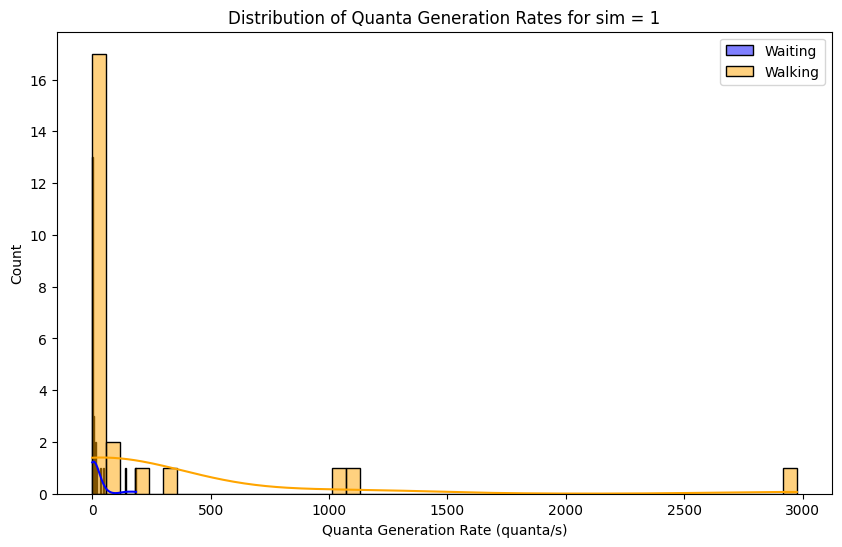

Median waiting quanta generation rate (quanta/s): 3.1687
Median walking quanta generation rate (quanta/s): 7.0446


In [47]:
# Get all unique new_track_id from tb_pos_df
track_ids = []
for idx, row in tb_pos_df.iterrows():
	positions = row['positions']
	positions = ast.literal_eval(row['positions'])
	if positions == '[]':
		continue
	for pos in positions:
		track_ids.append(pos[0])

track_ids = list(set(track_ids))

# Get waiting and walking quanta rates for these track_ids for sim=1
waiting_quanta = [quanta_waiting[tid][sim-1] * 3600 for tid in track_ids if tid in quanta_waiting]
walking_quanta = [quanta_walking[tid][sim-1] * 3600  for tid in track_ids if tid in quanta_walking]

plt.figure(figsize=(10, 6))
sns.histplot(waiting_quanta, bins=50, color='blue', label='Waiting', kde=True)
sns.histplot(walking_quanta, bins=50, color='orange', label='Walking', kde=True)
plt.xlabel('Quanta Generation Rate (quanta/s)')
plt.ylabel('Count')
plt.title('Distribution of Quanta Generation Rates for sim = 1')
plt.legend()
plt.show()
print(f"Median waiting quanta generation rate (quanta/s): {np.median(waiting_quanta):.4f}")
print(f"Median walking quanta generation rate (quanta/s): {np.median(walking_quanta):.4f}")

### Run simulation of quanta concentration

In [48]:
solver, idx_map, keep = spd.prepare_be_solver(mask, cell_size, diffusion_rate, aer + (1 + 1.5) / 3600, 1.0)

quanta_list = []
quanta = np.zeros_like(mask, dtype=float)
for idx, row in tb_s1.iterrows():
	# Use positions and dt from the current row
	# positions = ast.literal_eval(row['positions'])
	positions = row['positions']
	positions = [(z, y, r) for (_, y, z, r) in positions] if positions != [] else []
	duration = row['dt']

	# Solve diffusion for this segment
	_, quanta_new = spd.solve_diffusion_be(
		quanta, positions, (0, duration), 1, solver, idx_map, keep, mask
	)

	# Append the result (excluding the initial state to avoid duplication)
	quanta_list.append(quanta_new[1:])

	# Start next loop with the last matrix of previous result
	quanta = quanta_new[-1]

# Concatenate all results along the time axis
quanta = np.concatenate(quanta_list, axis=0)

/Users/nb22i345/Documents/PostDoc/patient_flows/.venv/lib/python3.12/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve


### Inspect the concentration at some time points

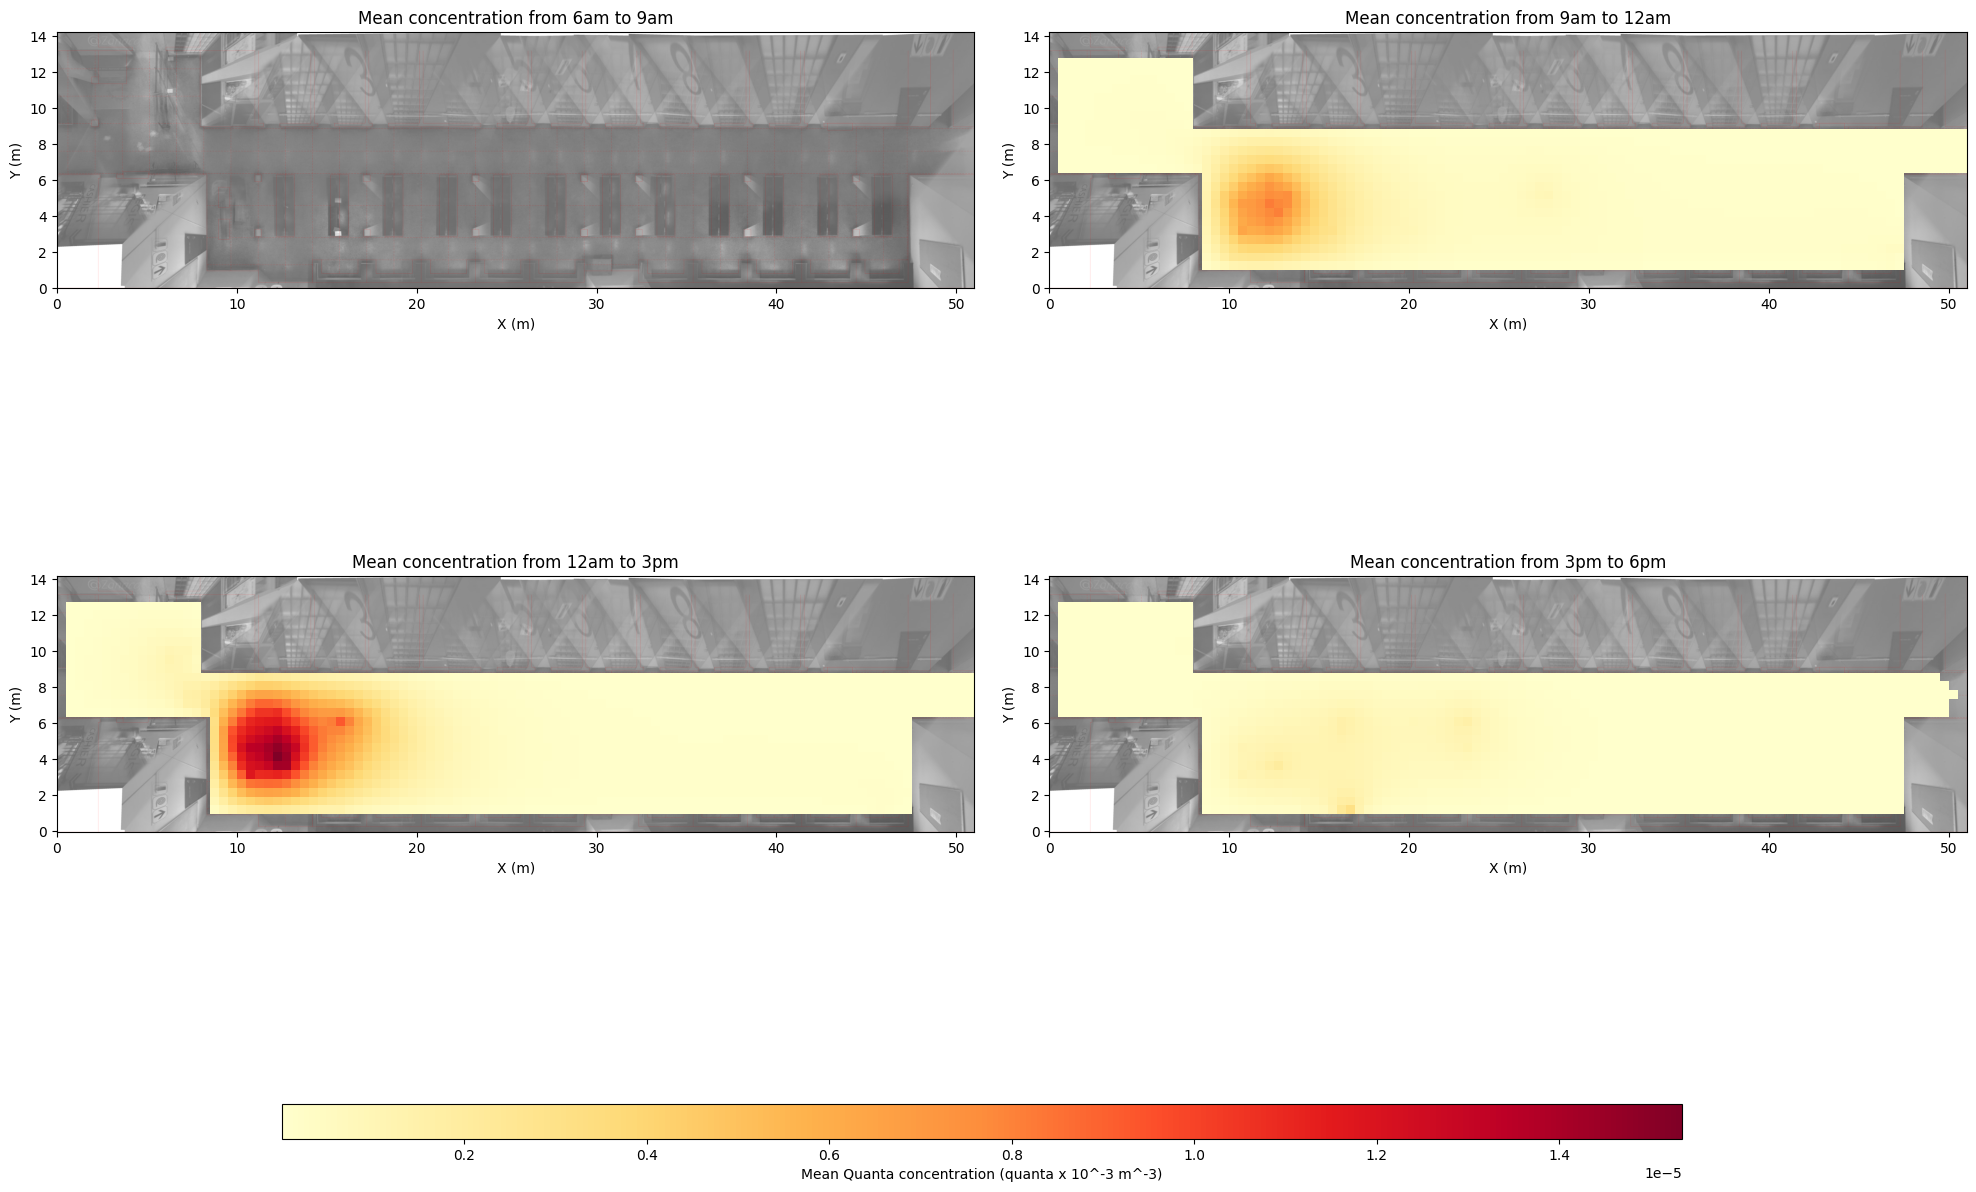

In [49]:
# Define time period indices (assuming time steps are in seconds)
periods = [
	(0, 3*3600),           # 6am to 9am
	(3*3600+1, 6*3600),    # 9am to 12am
	(6*3600+1, 9*3600),    # 12am to 3pm
	(9*3600+1, 12*3600)    # 3pm to 6pm
]
titles = [
	"Mean concentration from 6am to 9am",
	"Mean concentration from 9am to 12am",
	"Mean concentration from 12am to 3pm",
	"Mean concentration from 3pm to 6pm"
]

# Compute mean concentration for each period
mean_concentrations = [
	10**(-3) * np.mean(quanta[start:end+1], axis=0) for start, end in periods
]

# Create colormap with transparency for zero values
base_cmap = plt.get_cmap('YlOrRd').copy()
base_cmap.set_under(alpha=0)

vmin = min(np.min(mc) for mc in mean_concentrations)
vmax = max(np.max(mc) for mc in mean_concentrations)

fig, axes = plt.subplots(2, 2, figsize=(20, 14))
axes = axes.flatten()

ims = []
for ax, mc, title in zip(axes, mean_concentrations, titles):
	plot_with_background(ax, alpha=1)
	ax.set_xlim([x1, x2])
	ax.set_ylim([y1, y2])
	im = ax.imshow(
		mc,
		origin='lower',
		extent=[x1, x2, y1, y2],
		cmap=base_cmap,
		vmin=max(vmin, 1e-12),
		vmax=vmax,
		zorder=1
	)
	ims.append(im)
	ax.set_title(title)
	ax.set_xlabel("X (m)")
	ax.set_ylabel("Y (m)")

plt.tight_layout(rect=[0, 0.05, 1, 1])
cbar_ax = fig.add_axes([0.15, 0.02, 0.7, 0.025])
fig.colorbar(ims[0], cax=cbar_ax, orientation='horizontal', label='Mean Quanta concentration (quanta x 10^-3 m^-3)')
plt.show()


## Simulate risk of infection

In [50]:
def compute_individual_quanta_and_risk(sus_pos_df, quanta, new_track_id, V, ihr_wait, ihr_walk):
	start_time = 7200
	df = sus_pos_df[sus_pos_df['new_track_id'] == new_track_id]
	if df.empty:
		return (0, 0.0, 0.0)
	# Extract arrays
	t_idx = (df['time'].values - start_time).astype(int)
	x_idx = df['x_i'].values.astype(int)
	y_idx = df['y_k'].values.astype(int)
	is_walking = df['is_walking'].values
	# Get quanta concentrations for all positions
	c = quanta[t_idx, y_idx, x_idx]
	c = np.maximum(c, 0)
	# Select inhalation rate per activity
	ihr = np.where(is_walking == 1, ihr_walk, ihr_wait)
	# Vectorized sum
	Q = np.sum(c  * ihr / V)
	T = len(df)
	P = 1 - np.exp(-Q)
	return (T, Q, P * 100)

In [51]:
def compute_quanta_and_risk_group(df_group, quanta, V, ihr_wait, ihr_walk):
	t_idx = (df_group['time'].values - 7200).astype(int)
	x_idx = df_group['x_i'].values.astype(int)
	y_idx = df_group['y_k'].values.astype(int)
	is_walking = df_group['is_walking'].values
	c = quanta[t_idx, y_idx, x_idx]
	c = np.maximum(c, 0)
	ihr = np.where(is_walking == 1, ihr_walk, ihr_wait)
	Q = np.sum(c * ihr / V)
	T = len(df_group)
	P = 1 - np.exp(-Q)
	return T, Q, P * 100

results = [
	{'new_track_id': track_id, 'T': T, 'Q': Q, 'P': P}
	for track_id, group in non_tb_ps_df.groupby('new_track_id')
	for T, Q, P in [compute_quanta_and_risk_group(group, quanta, cell_volume, inhalation_rate_waiting, inhalation_rate_walking)]
]

risk_df = pd.DataFrame(results).sort_values(by='P', ascending=False)
risk_df

,new_track_id,T,Q,P
9550,265057,7530,2.037579e-02,2.016961
8688,260282,3817,1.520239e-02,1.508741
8877,261394,5838,1.336747e-02,1.327853
7850,255823,7717,1.142037e-02,1.135541
8882,261435,3460,1.101615e-02,1.095569
...,...,...,...,...
2499,228653,72,0.000000e+00,0.000000
2498,228646,14,0.000000e+00,0.000000
2497,228645,1436,0.000000e+00,0.000000
2496,228643,31,0.000000e+00,0.000000


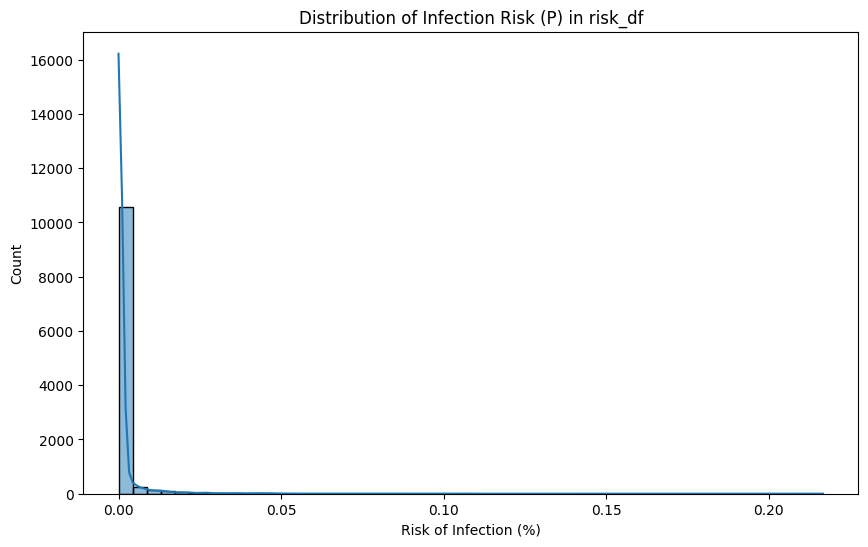

In [22]:
plt.figure(figsize=(10, 6))
sns.histplot(risk_df['P'], bins=50, kde=True)
plt.xlabel('Risk of Infection (%)')
plt.ylabel('Count')
plt.title('Distribution of Infection Risk (P) in risk_df')
plt.show()

In [23]:
# Compute cumulative time in hours and cumulative risk
total_time_hours = risk_df['T'].sum() / 3600
total_risk = risk_df['P'].sum()

# Compute risk per hour
risk_per_hour = total_risk / total_time_hours if total_time_hours > 0 else 0

# Compute risk per year (12 one-hour visits per year)
risk_per_year = risk_per_hour * 12

print(f"Cumulative risk (%) per hour: {risk_per_hour:,.4f}")
print(f"Cumulative risk (%) per year (12 one-hour visits): {risk_per_year:,.4f}")


Cumulative risk (%) per hour: 0.0154
Cumulative risk (%) per year (12 one-hour visits): 0.1846
